In [2]:
import os
import sys

import pandas as pd
import numpy as np

import torch
import tensorflow as tf
import keras

from torch.utils.data import Subset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler

from utils.TSDataset import TimeSeriesDataset
from utils.TSDataset import data_load
from utils.plot import *
from utils.split_train_val_test import *
from utils.compute_metric import compute_metrics, append_score, append_model
from utils.compute_metric import compute_metrics_seq2seq
from utils.models import cnn_lstm_model_eval

import matplotlib as mpl
import matplotlib.pyplot as plt


In [3]:
project_dir = os.path.dirname(os.path.abspath('__file__'))
if not os.path.exists(os.path.join(project_dir, 'output')):
    os.makedirs(os.path.join(project_dir, 'output'))
output_dir = os.path.join(project_dir, 'output')
project_dir

data_path = os.path.join(project_dir, 'data', 'processed', 'BTC-USD-sample.csv')

# Load data
data1, x_scaler1, y_scaler1 = data_load(data_path, x_scaler='minmax', y_scaler='minmax')

# Multi-Step Prediction

In [4]:
record = []
models = []

In [4]:
forecast_horizons = [1, 10, 60]
train_df, test_df = split_train_val_test(data1, train_frac=0.7)
scores = []
target_col = 'y'

test_target = test_df[target_col].values

for h in forecast_horizons:
    naive_y_true = []  # will hold the true future values for every forecasting window
    naive_y_pred = []  # will hold the corresponding naive predictions
    
    for i in range(len(test_target) - h):
        # True values: for instance, at time step 0, this gets indices 1 to h (i.e., 1:11 when h=10)
        y_true = test_target[i + 1: i + h + 1]
        # Naive predictions: create an array of length h filled with the value at time step i
        y_pred = np.full((h,), test_target[i])
        
        naive_y_true.append(y_true)
        naive_y_pred.append(y_pred)
    
    naive_y_true = y_scaler1.inverse_transform(naive_y_true)
    naive_y_pred = y_scaler1.inverse_transform(naive_y_pred)
    mse_naive, mae_naive = compute_metrics(naive_y_true, naive_y_pred)
    
    # Print out the performance for this forecast horizon
    record = {
        'model': 'Naive',
        'h-step Forecast': h,
        'mse': mse_naive,
        'mae': mae_naive,
        'rmse': np.sqrt(mse_naive)
    }
    append_score(scores, record)
for i in scores:
    print(i)

{'model': 'Naive', 'h-step Forecast': 1, 'mse': 1104.364187312189, 'mae': 24.323772954924898, 'rmse': np.float64(33.23197537481317)}
{'model': 'Naive', 'h-step Forecast': 10, 'mse': 4624.270194508474, 'mae': 49.49623050847454, 'rmse': np.float64(68.00198669530526)}
{'model': 'Naive', 'h-step Forecast': 60, 'mse': 29212.67957872223, 'mae': 108.93083765432101, 'rmse': np.float64(170.91717169062397)}


In [85]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from bayes_opt import BayesianOptimization
# Import your custom functions and classes
from utils.TSDataset import TimeSeriesDataset
from utils.split_train_val_test import split_train_val_test
from utils.compute_metric import compute_metrics_seq2seq, compute_metrics

# =============================================================================
# Instantiate Chosen Hyperparameters & Other Variables
# =============================================================================
data_frame = data1
scaler = y_scaler1
strides = 1
forecast_horizon = 1    # This may be updated based on your forecast horizon loop
feature_cols = ['x1', 'x2', 'x3', 'x4', 'x5']
target_col = 'y'
return_index = True
seq2seq = True

# Define the output directory for models
output_dir = "model_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# =============================================================================
# Loop Through Different Forecast Horizons
# =============================================================================
for h in forecast_horizons:
    # Define parameter bounds for Bayesian Optimization.
    pbounds = {
        'filters': (16, 64),
        'kernel_size': (2, 6),
        'lstm_units': (16, 64),
        'learning_rate': (1e-5, 1e-1),
        'epochs': (20, 100),
        'window_size': (50, 200)
    }
    
    # Define the objective function for Bayesian Optimization.
    def cnn_lstm_model_eval_hpo(filters, window_size, kernel_size, lstm_units, learning_rate, epochs):
        return cnn_lstm_model_eval(
            data_frame=data_frame,
            feature_cols=feature_cols,
            target_col=target_col,
            return_index=return_index,
            scaler=scaler,
            filters=int(filters),
            window_size=int(window_size),
            kernel_size=int(kernel_size),
            strides=strides,
            lstm_units=int(lstm_units),
            learning_rate=learning_rate,
            epochs=int(epochs),
            seq2seq=seq2seq,
            forecast_horizon=h  # Use current horizon from the loop
        )
    
    print(f"===== Bayesian Optimization for CNN-LSTM {h}-step Forecast =====")
    optimizer_bo = BayesianOptimization(
        f=cnn_lstm_model_eval_hpo,
        pbounds=pbounds,
        random_state=42
    )
    optimizer_bo.maximize(init_points=1, n_iter=0)
    
    print(f"===== Optimizer Best Hyperparameters for CNN-LSTM {h}-step Forecast =====")
    best_hyperparameters = optimizer_bo.max
    print(f"Filters: {best_hyperparameters['params']['filters']}")
    print(f"Window Size: {best_hyperparameters['params']['window_size']}")
    print(f"Kernel Size: {best_hyperparameters['params']['kernel_size']}")
    print(f"LSTM Units: {best_hyperparameters['params']['lstm_units']}")
    print(f"Learning Rate: {best_hyperparameters['params']['learning_rate']}")
    print(f"Epochs: {best_hyperparameters['params']['epochs']}")
    
    # Extract hyperparameters to use for training
    filters = int(best_hyperparameters['params']['filters'])
    window_size = int(best_hyperparameters['params']['window_size'])
    kernel_size = int(best_hyperparameters['params']['kernel_size'])
    lstm_units = int(best_hyperparameters['params']['lstm_units'])
    learning_rate = best_hyperparameters['params']['learning_rate']
    epochs = int(best_hyperparameters['params']['epochs'])
    
    # Train the model using the chosen hyperparameters and current forecast horizon.
    cnn_lstm_mse, cnn_lstm_mae, cnn_lstm_history, model = cnn_lstm_model_eval(
        data_frame=data_frame,
        feature_cols=feature_cols,
        target_col=target_col,
        return_index=return_index,
        scaler=scaler,
        filters=filters,
        window_size=window_size,
        kernel_size=kernel_size,
        strides=strides,
        lstm_units=lstm_units,
        learning_rate=learning_rate,
        epochs=epochs,
        seq2seq=seq2seq,
        forecast_horizon=h,  # Pass current forecast horizon into model building
        optimize=False
    )
    
    # Save performance records
    record = {
        'model': 'CNN-LSTM',
        'h-step Forecast': h,
        'mse': -cnn_lstm_mse,
        'mae': cnn_lstm_mae,
        'rmse': np.sqrt(cnn_lstm_mse)
    }
    model_record = {
        'model': 'CNN-LSTM',
        'h-step Forecast': h,
        'model': model,  # The trained model object
        'filters': filters,
        'window_size': window_size,
        'kernel_size': kernel_size,
        'lstm_units': lstm_units,
        'learning_rate': learning_rate,
        'epochs': epochs
    }
    
    # Save the model to the output directory as an H5 file.
    model_filename = f"CNN_LSTM_{h}step.h5"
    model_path = os.path.join(output_dir, model_filename)
    model.save(model_path)
    print(f"Model saved to: {model_path}")
    
    # Append records to your score and model lists.
    append_model(models, model_record)
    append_score(scores, record)


===== Bayesian Optimization for CNN-LSTM 1-step Forecast =====
|   iter    |  target   |  epochs   |  filters  | kernel... | learni... | lstm_u... | window... |
-------------------------------------------------------------------------------------------------
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
| 1         | -724.0    | 49.96     | 61.63     | 4.928     | 0.05987   | 23.49     | 73.4      |
===== Optimizer Best Hyperparameters for CNN-LSTM 1-step Forecast =====
Filters: 61.634286707675976
Window Size: 73.3991780504304
Kernel Size: 4.92797576724562
LSTM Units: 23.488894741236955
Learning Rate: 0.0598698618348617
Epochs: 49.963209507789
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Model saved to: model_output/CNN_LSTM_1step.h5
===== Bayesian Optimization for CNN-LSTM 10-step Forecast =====
|   iter    |  target   |  epochs   |  filters  | kernel... | learni... | lstm_u... | window... |
-------------------------------------------------------------------------------------------------
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
| 1         | -7.55e+04 | 49.96     | 61.63     | 4.928     | 0.05987   | 23.49     | 73.4      |
===== Optimizer Best Hyperparameters for CNN-LSTM 10-step Forecast =====
Filters: 61.634286707675976
Window Size: 73.3991780504304
Kernel Size: 4.92797576724562
LSTM Units: 23.488894741236955
Learning Rate: 0.0598698618348617
Epochs: 49.963209507789
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Model saved to: model_output/CNN_LSTM_10step.h5
===== Bayesian Optimization for CNN-LSTM 60-step Forecast =====
|   iter    |  target   |  epochs   |  filters  | kernel... | learni... | lstm_u... | window... |
-------------------------------------------------------------------------------------------------
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
| 1         | -9.213e+0 | 49.96     | 61.63     | 4.928     | 0.05987   | 23.49     | 73.4      |
===== Optimizer Best Hyperparameters for CNN-LSTM 60-step Forecast =====
Filters: 61.634286707675976
Window Size: 73.3991780504304
Kernel Size: 4.92797576724562
LSTM Units: 23.488894741236955
Learning Rate: 0.0598698618348617
Epochs: 49.963209507789
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


Model saved to: model_output/CNN_LSTM_60step.h5


In [61]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 50
forecast_horizons = [1, 10, 60]
for h in forecast_horizons:
    train_df, test_df = split_train_val_test(data1, train_frac=0.7)
    train_set = TimeSeriesDataset(dataframe=train_df, window_size=window_size, forecast_horizon=h, feature_cols=feature_cols, target_col=target_col, return_index=return_index)
    test_set = TimeSeriesDataset(dataframe=test_df, window_size=window_size, forecast_horizon=h, feature_cols=feature_cols, target_col=target_col, return_index=return_index)

    X_train, y_train, x_dates, y_dates = train_set.X_seq, train_set.y_seq, train_set.x_dates, train_set.y_dates
    X_test, y_test, x_dates_test, y_dates_test = test_set.X_seq, test_set.y_seq, test_set.x_dates, test_set.y_dates

    dense_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, len(feature_cols))),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(h)
    ])

    dense_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    history_dense = dense_model.fit(X_train, y_train, epochs=50,
                                    validation_data=(X_test, y_test), verbose=0)

    #plot_learning_curves(history_dense.history)
    y_pred = dense_model.predict(X_test)
    y_pred_flat = y_scaler1.inverse_transform(y_pred.reshape(-1, 1))
    y_true_flat = y_scaler1.inverse_transform(y_test.reshape(-1, 1))
    
    mse_dense, mae_dense = compute_metrics(y_true_flat, y_pred_flat)
    
    record = {
        'model': 'Dense',
        'h-step Forecast': h,
        'mse': mse_dense,
        'mae': mae_dense,
        'rmse': np.sqrt(mse_dense)
    }
    append_score(scores, record)
    
    last_train = y_train[-3:]
    true_future = y_test[:1]
    predicted_future = y_pred[:1]
    plot_forecast(last_train, true_future, predicted_future, output_dir, f'Dense_{h}_step', scaler=y_scaler1)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

for h in forecast_horizons:
    train_df, test_df = split_train_val_test(data1, train_frac=0.7)
    train_set = TimeSeriesDataset(dataframe=train_df, window_size=window_size, forecast_horizon=h, feature_cols=feature_cols, target_col=target_col, return_index=return_index)
    test_set = TimeSeriesDataset(dataframe=test_df, window_size=window_size, forecast_horizon=h, feature_cols=feature_cols, target_col=target_col, return_index=return_index)

    X_train, y_train, x_dates, y_dates = train_set.X_seq, train_set.y_seq, train_set.x_dates, train_set.y_dates
    X_test, y_test, x_dates_test, y_dates_test = test_set.X_seq, test_set.y_seq, test_set.x_dates, test_set.y_dates

    rnn_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, len(feature_cols))),
        tf.keras.layers.SimpleRNN(units=20),
        tf.keras.layers.Dense(h)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    rnn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    history_rnn = rnn_model.fit(X_train, y_train, epochs=20,
                                validation_data=(X_test, y_test), verbose=0)

    y_pred = rnn_model.predict(X_test)
    y_pred_flat = y_scaler1.inverse_transform(y_pred.reshape(-1, 1))
    y_true_flat = y_scaler1.inverse_transform(y_test.reshape(-1, 1))
    
    mse_rnn, mae_rnn = compute_metrics(y_true_flat, y_pred_flat)
    
    record = {
        'model': 'Simple RNN',
        'h-step Forecast': h,
        'mse': mse_rnn,
        'mae': mae_rnn,
        'rmse': np.sqrt(mse_rnn)
    }
    append_score(scores, record)
    
    last_train = y_train[-3:]
    true_future = y_test[:1]
    predicted_future = y_pred[:1]
    plot_forecast(last_train, true_future, predicted_future, output_dir, f'SimpleRNN_{h}_step', scaler=y_scaler1)
    plot_learning_curves(history_rnn.history, output_dir, f'SimpleRNN_{h}_step_learning_curves')

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

for h in forecast_horizons:
    train_df, test_df = split_train_val_test(data1, train_frac=0.7)
    train_set = TimeSeriesDataset(dataframe=train_df, window_size=window_size, forecast_horizon=h, feature_cols=feature_cols, target_col=target_col, return_index=return_index)
    test_set = TimeSeriesDataset(dataframe=test_df, window_size=window_size, forecast_horizon=h, feature_cols=feature_cols, target_col=target_col, return_index=return_index)

    X_train, y_train, x_dates, y_dates = train_set.X_seq, train_set.y_seq, train_set.x_dates, train_set.y_dates
    X_test, y_test, x_dates_test, y_dates_test = test_set.X_seq, test_set.y_seq, test_set.x_dates, test_set.y_dates

    rnn_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, len(feature_cols))),
    tf.keras.layers.SimpleRNN(units=20, return_sequences=True),
    tf.keras.layers.SimpleRNN(units=20, return_sequences=False),
    tf.keras.layers.Dense(h)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    rnn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    history_rnn = rnn_model.fit(X_train, y_train, epochs=20,
                                validation_data=(X_test, y_test), verbose=0)

    y_pred = rnn_model.predict(X_test)
    y_pred_flat = y_scaler1.inverse_transform(y_pred.reshape(-1, 1))
    y_true_flat = y_scaler1.inverse_transform(y_test.reshape(-1, 1))
    
    mse_rnn, mae_rnn = compute_metrics(y_true_flat, y_pred_flat)
    
    record = {
        'model': 'Deep RNN',
        'h-step Forecast': h,
        'mse': mse_rnn,
        'mae': mae_rnn,
        'rmse': np.sqrt(mse_rnn)
    }
    append_score(scores, record)
    last_train = y_train[-3:]
    true_future = y_test[:1]
    predicted_future = y_pred[:1]
    plot_forecast(last_train, true_future, predicted_future, output_dir, f'DeepRNN_{h}_step', scaler=y_scaler1)
    #plot_learning_curves(history_rnn.history)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

for h in forecast_horizons:
    train_df, test_df = split_train_val_test(data1, train_frac=0.7)
    train_set = TimeSeriesDataset(dataframe=train_df, window_size=window_size, forecast_horizon=h, feature_cols=feature_cols, target_col=target_col, return_index=return_index)
    test_set = TimeSeriesDataset(dataframe=test_df, window_size=window_size, forecast_horizon=h, feature_cols=feature_cols, target_col=target_col, return_index=return_index)

    X_train, y_train, x_dates, y_dates = train_set.X_seq, train_set.y_seq, train_set.x_dates, train_set.y_dates
    X_test, y_test, x_dates_test, y_dates_test = test_set.X_seq, test_set.y_seq, test_set.x_dates, test_set.y_dates

    rnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window_size, len(feature_cols))),
    tf.keras.layers.SimpleRNN(units=20, return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SimpleRNN(units=20, return_sequences=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(h)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    rnn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    history_rnn = rnn_model.fit(X_train, y_train, epochs=20,
                                validation_data=(X_test, y_test), verbose=0)

    y_pred = rnn_model.predict(X_test)
    y_pred_flat = y_scaler1.inverse_transform(y_pred.reshape(-1, 1))
    y_true_flat = y_scaler1.inverse_transform(y_test.reshape(-1, 1))
    
    mse_rnn, mae_rnn= compute_metrics(y_true_flat, y_pred_flat)
    
    record = {
        'model': 'RNN Batch Normalization',
        'h-step Forecast': h,
        'mse': mse_rnn,
        'mae': mae_rnn,
        'rmse': np.sqrt(mse_rnn)
    }
    append_score(scores, record)
    last_train = y_train[-3:]
    true_future = y_test[:1]
    predicted_future = y_pred[:1]
    plot_forecast(last_train, true_future, predicted_future, output_dir, f'RNN_Batch_Normalization_{h}_step', scaler=y_scaler1)
    #plot_learning_curves(history_rnn.history)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

for h in forecast_horizons:
    train_df, test_df = split_train_val_test(data1, train_frac=0.7)
    train_set = TimeSeriesDataset(dataframe=train_df, window_size=window_size, forecast_horizon=h, feature_cols=feature_cols, target_col=target_col, return_index=return_index)
    test_set = TimeSeriesDataset(dataframe=test_df, window_size=window_size, forecast_horizon=h, feature_cols=feature_cols, target_col=target_col, return_index=return_index)

    X_train, y_train, x_dates, y_dates = train_set.X_seq, train_set.y_seq, train_set.x_dates, train_set.y_dates
    X_test, y_test, x_dates_test, y_dates_test = test_set.X_seq, test_set.y_seq, test_set.x_dates, test_set.y_dates

    rnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window_size, len(feature_cols))),
    tf.keras.layers.LSTM(units=20, return_sequences=True),
    tf.keras.layers.LSTM(units=20, return_sequences=False),
    tf.keras.layers.Dense(h)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    rnn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    history_rnn = rnn_model.fit(X_train, y_train, epochs=20,
                                validation_data=(X_test, y_test), verbose=0)

    y_pred = rnn_model.predict(X_test)
    y_pred_flat = y_scaler1.inverse_transform(y_pred.reshape(-1, 1))
    y_true_flat = y_scaler1.inverse_transform(y_test.reshape(-1, 1))
    
    mse_rnn, mae_rnn = compute_metrics(y_true_flat, y_pred_flat)
    
    record = {
        'model': 'LSTM',
        'h-step Forecast': h,
        'mse': mse_rnn,
        'mae': mae_rnn,
        'rmse': np.sqrt(mse_rnn)
    }
    append_score(scores, record)
    last_train = y_train[-3:]
    true_future = y_test[:1]
    predicted_future = y_pred[:1]
    plot_forecast(last_train, true_future, predicted_future, output_dir, f'LSTM_{h}_step', scaler=y_scaler1)
    #plot_learning_curves(history_rnn.history)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [19]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
for h in forecast_horizons:
    train_df, test_df = split_train_val_test(data1, train_frac=0.7)
    train_set = TimeSeriesDataset(dataframe=train_df, window_size=window_size, forecast_horizon=h, feature_cols=feature_cols, target_col=target_col, return_index=return_index)
    test_set = TimeSeriesDataset(dataframe=test_df, window_size=window_size, forecast_horizon=h, feature_cols=feature_cols, target_col=target_col, return_index=return_index)

    X_train, y_train, x_dates, y_dates = train_set.X_seq, train_set.y_seq, train_set.x_dates, train_set.y_dates
    X_test, y_test, x_dates_test, y_dates_test = test_set.X_seq, test_set.y_seq, test_set.x_dates, test_set.y_dates

    rnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window_size, len(feature_cols))),
    tf.keras.layers.GRU(units=20, return_sequences=True),
    tf.keras.layers.GRU(units=20, return_sequences=False),
    tf.keras.layers.Dense(h)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    rnn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    history_rnn = rnn_model.fit(X_train, y_train, epochs=3,
                                validation_data=(X_test, y_test), verbose=0)

    y_pred = rnn_model.predict(X_test)
    y_pred_flat = y_scaler1.inverse_transform(y_pred.reshape(-1, 1))
    y_true_flat = y_scaler1.inverse_transform(y_test.reshape(-1, 1))
    
    mse_rnn, mae_rnn = compute_metrics(y_true_flat, y_pred_flat)
    
    record = {
        'model': 'GRU',
        'h-step Forecast': h,
        'mse': mse_rnn,
        'mae': mae_rnn,
        'rmse': np.sqrt(mse_rnn)
    }
    append_score(scores, record)
    last_train = y_train[-3:]
    true_future = y_test[:1]
    predicted_future = y_pred[:1]
    plot_forecast(last_train, true_future, predicted_future, output_dir, f'GRU_{h}_step', scaler=y_scaler1)
    plot_learning_curves(history_rnn.history, output_dir, f'GRU_{h}_step_learning_curves')

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2260.300601311958
36.89531286557986
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9066.189421328347
74.35710891520749
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
29393.91911815973
124.31542240410676


In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 120
for h in forecast_horizons:
    train_df, test_df = split_train_val_test(data1, train_frac=0.7)
    train_set = TimeSeriesDataset(dataframe=train_df, window_size=window_size, forecast_horizon=h, feature_cols=feature_cols, target_col=target_col, return_index=return_index)
    test_set = TimeSeriesDataset(dataframe=test_df, window_size=window_size, forecast_horizon=h, feature_cols=feature_cols, target_col=target_col, return_index=return_index)

    X_train, y_train, x_dates, y_dates = train_set.X_seq, train_set.y_seq, train_set.x_dates, train_set.y_dates
    X_test, y_test, x_dates_test, y_dates_test = test_set.X_seq, test_set.y_seq, test_set.x_dates, test_set.y_dates

   
    cnn_model = keras.models.Sequential([
    keras.layers.Input(shape=(window_size, len(feature_cols))),
    keras.layers.Conv1D(filters=16, kernel_size=2, padding="valid"),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=False),
    keras.layers.Dense(h)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.004717880792838919)
    cnn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    history_rnn = cnn_model.fit(X_train, y_train, epochs=20,
                                validation_data=(X_test, y_test), verbose=0)

    y_pred = cnn_model.predict(X_test)
    y_pred_flat = y_scaler1.inverse_transform(y_pred.reshape(-1, 1))
    y_true_flat = y_scaler1.inverse_transform(y_test.reshape(-1, 1))
    
    mse_rnn, mae_rnn = compute_metrics(y_true_flat, y_pred_flat)
    
    cnn_lstm_record = {
        'model': 'CNN-LSTM',
        'h-step Forecast': h,
        'mse': mse_rnn,
        'mae': mae_rnn,
        'rmse': np.sqrt(mse_rnn)
    }
    append_score(scores, cnn_lstm_record)
    last_train = y_train[-3:]
    true_future = y_test[:1]
    predicted_future = y_pred[:1]
    plot_forecast(last_train, true_future, predicted_future, output_dir, f'CNN-LSTM_{h}_step', scaler=y_scaler1)
    plot_learning_curves(history_rnn.history, output_dir, f'CNN-LSTM_{h}_step_learning_curves')

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [22]:
for i in scores:
    print(i)

{'model': 'Naive', 'h-step Forecast': 1, 'mse': 1160.3737790527032, 'mae': 25.10380253502343, 'rmse': np.float64(34.06425955532724)}
{'model': 'Naive', 'h-step Forecast': 10, 'mse': 5275.25768559061, 'mae': 54.060173825503384, 'rmse': np.float64(72.6309691907702)}
{'model': 'Naive', 'h-step Forecast': 60, 'mse': 26082.668655180554, 'mae': 116.48661504629631, 'rmse': np.float64(161.50129614086865)}
{'model': 'Dense', 'h-step Forecast': 1, 'mse': 2823.5630960043377, 'mae': 41.70309861400797, 'rmse': np.float64(53.137210088640686)}
{'model': 'Dense', 'h-step Forecast': 10, 'mse': 9089.086129855012, 'mae': 73.93715745061219, 'rmse': np.float64(95.3366987568534)}
{'model': 'Dense', 'h-step Forecast': 60, 'mse': 28235.31242986069, 'mae': 121.62153472514966, 'rmse': np.float64(168.03366457308692)}
{'model': 'Simple RNN', 'h-step Forecast': 1, 'mse': 3643.8089953961585, 'mae': 46.769755750938806, 'rmse': np.float64(60.363971004202156)}
{'model': 'Simple RNN', 'h-step Forecast': 10, 'mse': 7492

In [9]:
from bayes_opt import BayesianOptimization

# Instantiate Chosen Hyperparameters
forecast_horizons = [1]
data_frame = data1
scaler = y_scaler1
strides = 1
feature_cols = ['x1', 'x2', 'x3', 'x4', 'x5']
target_col = 'y'
return_index = True
scaler = y_scaler1
seq2seq = True

for h in forecast_horizons:
    pbounds = {
        'filters': (16, 64),
        'kernel_size': (2, 6),
        'lstm_units': (16, 64),
        'learning_rate': (1e-5, 1e-1),
        'epochs': (20, 100),
        'window_size': (50, 200)
    }
    # Define the objective function for Bayesian Optimization
    def cnn_lstm_model_eval_hpo(filters, window_size, kernel_size, lstm_units, learning_rate, epochs):
        return cnn_lstm_model_eval(
            data_frame=data_frame,
            feature_cols=feature_cols,
            target_col=target_col,
            return_index=return_index,
            scaler=scaler,
            filters=int(filters),
            window_size= int(window_size),
            kernel_size=int(kernel_size),
            strides=strides,
            lstm_units=int(lstm_units),
            learning_rate=learning_rate,
            epochs=int(epochs),
            seq2seq=seq2seq,
            forecast_horizon=h
        )

    print(f"===== Bayesian Optimization for CNN-LSTM {h}-step Forecast =====")
    optimizer_bo = BayesianOptimization(
        f=cnn_lstm_model_eval_hpo,
        pbounds=pbounds,
        random_state=42
    )

    optimizer_bo.maximize(init_points=4, n_iter=4)

    print("===== Optimizer Best Hyperparameters for CNN-LSTM {h}-step Forecast =====")
    best_hyperparameters = optimizer_bo.max
    print(f"Filters: {best_hyperparameters['params']['filters']}")
    print(f"Window Size: {best_hyperparameters['params']['window_size']}")
    print(f"Kernel Size: {best_hyperparameters['params']['kernel_size']}")
    print(f"LSTM Units: {best_hyperparameters['params']['lstm_units']}")
    print(f"Learning Rate: {best_hyperparameters['params']['learning_rate']}")
    print(f"Epochs: {best_hyperparameters['params']['epochs']}")


    filters = int(best_hyperparameters['params']['filters'])
    window_size = int(best_hyperparameters['params']['window_size'])
    kernel_size = int(best_hyperparameters['params']['kernel_size'])
    lstm_units = int(best_hyperparameters['params']['lstm_units'])
    learning_rate = best_hyperparameters['params']['learning_rate']
    epochs = int(best_hyperparameters['params']['epochs'])

    cnn_lstm_mse, cnn_lstm_mae, cnn_lstm_history, model = cnn_lstm_model_eval(data_frame = data_frame,
                        feature_cols = feature_cols,
                        target_col = target_col,
                        return_index = return_index,
                        scaler = scaler,
                        filters = filters,
                        window_size = window_size,
                        kernel_size = kernel_size,
                        strides = strides,
                        lstm_units = lstm_units,
                        learning_rate = learning_rate,
                        epochs = epochs,
                        seq2seq = seq2seq,
                        forecast_horizon = forecast_horizon,
                        optimize = False)

    record = {
        'model': 'CNN-LSTM',
        'h-step Forecast': h,
        'mse': -cnn_lstm_mse,
        'mae': cnn_lstm_mae,
        'rmse': np.sqrt(cnn_lstm_mse)
    }
    model_record = {
        'model': 'CNN-LSTM',
        'h-step Forecast': h,
        'model': model,
        'filters': filters,
        'window_size': window_size,
        'kernel_size': kernel_size,
        'lstm_units': lstm_units,
        'learning_rate': learning_rate,
        'epochs': epochs
    }
    append_model(models, model_record)
    append_score(scores, record)

===== Bayesian Optimization for CNN-LSTM 1-step Forecast =====
|   iter    |  target   |  epochs   |  filters  | kernel... | learni... | lstm_u... | window... |
-------------------------------------------------------------------------------------------------
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
| 1         | -1.016e+0 | 49.96     | 61.63     | 4.928     | 0.05987   | 23.49     | 73.4      |
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
| 2         | -3.5e+05  | 24.65     | 57.58     | 4.404     | 0.07081   | 16.99     | 195.5     |
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 3         | -2.16e+04 | 86.6      | 26.19     | 2.727     | 0.01835   | 30.6      | 128.7     |


KeyboardInterrupt: 

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


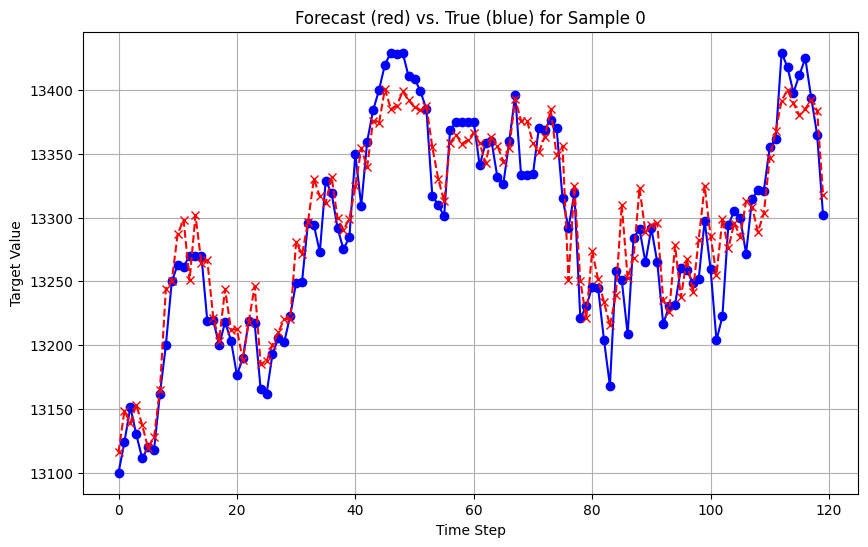

In [8]:
filters = int(61.634286707675976)
window_size = 120
kernel_size = 2
lstm_units = int(23.488894741236955)
learning_rate = 0.0598698618348617
epochs = int(49.963209507789)
strides = 1
seq2seq = True

data_frame = data1
feature_cols = ['x1', 'x2', 'x3', 'x4', 'x5']
target_col = 'y'
return_index = False
scaler = y_scaler1
forecast_horizon = 1

y_pred, y_true = cnn_lstm_model_eval(data_frame = data_frame, 
                                     feature_cols = feature_cols, 
                                     target_col = target_col, 
                                     return_index = return_index, 
                                     scaler = scaler, 
                                     filters = filters, 
                                     window_size = window_size, 
                                     kernel_size = kernel_size, 
                                     strides = strides, 
                                     lstm_units = lstm_units, 
                                     learning_rate = learning_rate, 
                                     epochs = epochs, 
                                     seq2seq = seq2seq, 
                                     forecast_horizon = forecast_horizon, 
                                     optimize = False,
                                     results = True)

plot_single_forecast(y_true, y_pred, sample_index=0)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


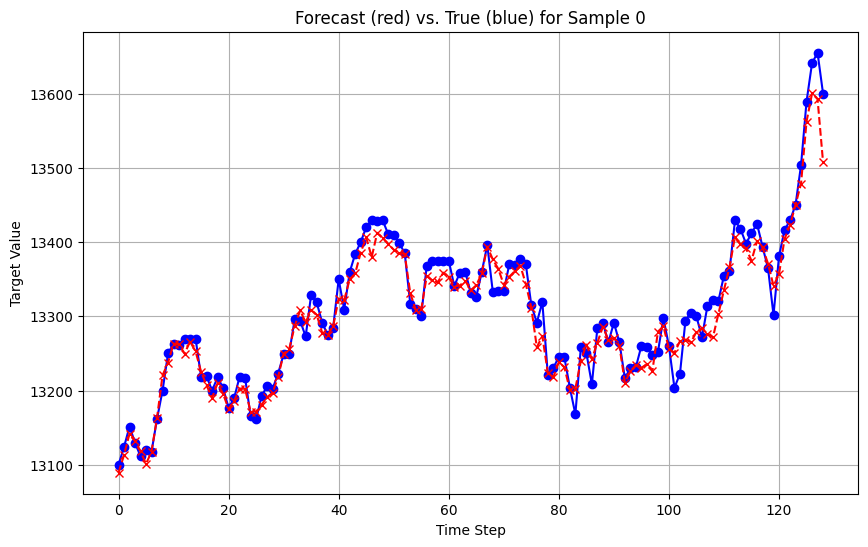

In [11]:
filters = 26
window_size = 129
kernel_size = 3
lstm_units = 31
learning_rate = 0.01835
epochs = 87
strides = 1
seq2seq = True



data_frame = data1
feature_cols = ['x1', 'x2', 'x3', 'x4', 'x5']
target_col = 'y'
return_index = False
scaler = y_scaler1
forecast_horizon = 1

y_pred, y_true = cnn_lstm_model_eval(data_frame = data_frame, 
                                     feature_cols = feature_cols, 
                                     target_col = target_col, 
                                     return_index = return_index, 
                                     scaler = scaler, 
                                     filters = filters, 
                                     window_size = window_size, 
                                     kernel_size = kernel_size, 
                                     strides = strides, 
                                     lstm_units = lstm_units, 
                                     learning_rate = learning_rate, 
                                     epochs = epochs, 
                                     seq2seq = seq2seq, 
                                     forecast_horizon = forecast_horizon, 
                                     optimize = False,
                                     results = True)

plot_single_forecast(y_true, y_pred, sample_index=0)